In [317]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots, db
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 8
fs_title = 10
rcParams['font.size'] = default_font
rcParams['axes.titlesize'] = fs_title
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
def filter_neurons(m, area, celltype):
        try:
            ia = utils.get_region_idx(m.iarea, area)
        except:
            AssertionError("area must be 'V1', 'medial', 'lateral' or 'anterior'")
        if celltype == "Pyr":
            selected_type = np.logical_not(m.isred[:,0]).astype(bool)
        elif celltype == "Int":
            selected_type = m.isred[:,0].astype(bool)
        else:
            AssertionError("celltype must be 'Pyr' or 'Int' or None")
        selection = ia * selected_type
        prop = selection.sum() / ia.sum()
        return selection, prop

In [172]:
def sig_variance(resp, stimid, zscore = False):
    # this function computers signal variance based on repeated presentations of the same stimuli
    # if you have more than two repeats, this can take advantage of that (equivalent to forming all pairs of repeats)

    # resp = (neurons, #stimuli)
    # stimid = (#stimuli)

    # example cc = sig_variance(resp, stimid)

    iunq = np.unique(stimid)
    if zscore:
        R = zscore(resp, 1)
    else:
        R = resp
    NN = resp.shape[0]
    cc = np.zeros(NN,)    
    nsum = 0
    for j in range(len(stimid)):
        iss = stimid==stimid[j]
        if iss.sum()<2:
            continue;
        cc += (R[:, j] * (R[:, iss].sum(1) - R[:, j])) / (iss.sum()-1)
        nsum += 1 
    if nsum<2:
        raise ValueError('Found %d stimuli with at least two repeats. Requires at least 2.'%nsum)
    cc /= nsum
    return cc

In [ ]:
def get_sim_matrix(m, id_responses, area, category, celltype=None):
    nneurons = id_responses.shape[0]
    id_resp_idx = id_responses.reshape(nneurons, 102, 400)
    from itertools import combinations
    representation_matrix = np.ones((102,102)) * np.nan
    pairs = list(combinations(np.arange(102),2))
    selection, _ = filter_neurons(m, area, category, celltype=celltype)
    id_area = id_resp_idx[selection,:,0:100].mean(2)
    for pair in pairs:
        instance_a = id_area[:,pair[0]]
        instance_b = id_area[:,pair[1]]
        corr = np.corrcoef(instance_a, instance_b)[0,1]
        representation_matrix[pair[0],pair[1]] = corr
        representation_matrix[pair[1],pair[0]] = corr
    return representation_matrix

In [2]:
dbase = db.get_sessions()

In [46]:
example_sess = dbase.query("mname == 'VG14' & session == 'last training' & round_id == 1")

In [212]:
name, datexp, blk = example_sess["mname"].values[0], example_sess["datexp"].values[0], example_sess["blk"].values[0]
m = utils.load_mouse(name, datexp, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])


In [229]:
frameselector = utils.get_frameselector(m)
istim_df = pd.DataFrame(m._timeline['istim'], columns=['istim'])
istim_df["trial_no"] = np.arange(1, len(istim_df)+1).astype(float)
m.frameselector = (frameselector.reset_index()
    .rename(columns = {'index':'frame'})
    .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
    .set_index('frame'))

In [239]:
mask_B = m.frameselector['trial_type'].isin(['non rewarded', 'non rewarded test'])
base = m.frameselector['istim'].astype('Int64') - 1  # zero-based
m.frameselector['stim_id_matrix'] =np.where(~mask_B, base, base + 51)

In [243]:
# retrieve for each unique trial_no the corresponding stim_id_matrix
stim_ids = []
for tn in m.frameselector['trial_no'].unique():
    stim_ids.append(m.frameselector.loc[m.frameselector['trial_no'] == tn, 'stim_id_matrix'].values[0])
stim_ids = np.array(stim_ids)
# now lets get the zscore responses per trial
resp = m.interp_spks[:,:,:100].mean(2)
print(resp.shape)
print(stim_ids.shape)

(29439, 371)
(371,)


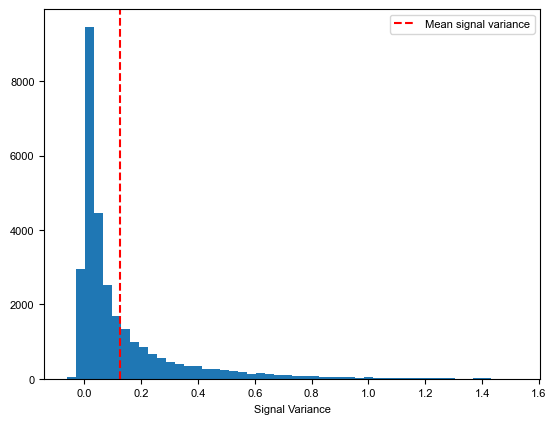

In [244]:
cc = sig_variance(resp, stim_ids) # get signal var
plt.hist(cc, bins=50);
#plot mean 
plt.axvline(cc.mean(), color='r', linestyle='--', label='Mean signal variance')
plt.xlabel('Signal Variance')
plt.legend()

In [275]:
def get_istim_matrix(m, area: str, celltype: str, cc_tsh: float = 0.1) -> np.ndarray:
    selection, _ = filter_neurons(m, area, celltype)
    # ensure column exists (zero-based, as created above)
    if 'stim_id_matrix' not in m.frameselector.columns:
        mask_B = m.frameselector['trial_type'].isin(['non rewarded', 'non rewarded test'])
        base = m.frameselector['istim'].astype('Int64') - 1  # zero-based
        m.frameselector['stim_id_matrix'] =np.where(~mask_B, base, base + 51)

    # per-trial response over first 100 positions
    per_trial_resp = m.interp_spks[:, :, :100].mean(2)  # (neurons, trials)
    # get stim ids
    stim_ids = []
    for tn in m.frameselector['trial_no'].unique():
        stim_ids.append(m.frameselector.loc[m.frameselector['trial_no'] == tn, 'stim_id_matrix'].values[0])
    stim_ids = np.array(stim_ids)
    cc = sig_variance(per_trial_resp, stim_ids)
    per_trial_resp = per_trial_resp[selection, :]  # filter neurons
    cc_region = cc[selection]
    sig_neurons = per_trial_resp[cc_region > cc_tsh]
    nneurons = sig_neurons.shape[0]
    id_responses = np.full((nneurons, 102, 2), np.nan, dtype=float)
    # build responses by stim id (0..101)
    stim_vals = m.frameselector['stim_id_matrix']
    for idx in range(102):
        mask = (stim_vals == idx)
        if mask.any():
            trials = m.frameselector.loc[mask, 'trial_no'].dropna().unique().astype(int) - 1
            if trials.size >= 2:
                id_responses[:, idx, 0] = sig_neurons[:, trials[0]]
                id_responses[:, idx, 1] = sig_neurons[:, trials[1]]
    print(id_responses.shape)
    id_responses = zscore(id_responses, axis=1, nan_policy='omit') #across textures
    return id_responses

In [276]:
stim_mtx = get_istim_matrix(m, area='medial', celltype='Pyr', cc_tsh=0.1)

(1967, 102, 2)


In [278]:
from itertools import combinations
pairs = list(combinations(np.arange(102),2))
representation_matrix = np.ones((102,102)) * np.nan
for pair in pairs:
    instance_a = stim_mtx[:,pair[0],:]
    instance_b = stim_mtx[:,pair[1],:]
    if np.isnan(instance_a).all() or np.isnan(instance_b).all():
        continue
    fh_neurons = instance_a.mean(axis=1)
    sh_neurons = instance_b.mean(axis=1)
    representation_matrix[pair[0],pair[1]] = np.corrcoef(fh_neurons, sh_neurons)[0,1]
    representation_matrix[pair[1],pair[0]] = np.corrcoef(fh_neurons, sh_neurons)[0,1]

In [292]:
def get_rsm(stim_mtx: np.ndarray) -> np.ndarray:
    from itertools import combinations
    pairs = list(combinations(np.arange(102),2))
    representation_matrix = np.ones((102,102)) * np.nan
    for pair in pairs:
        instance_a = stim_mtx[:,pair[0],:]
        instance_b = stim_mtx[:,pair[1],:]
        if np.isnan(instance_a).all() or np.isnan(instance_b).all():
            continue
        fh_neurons = instance_a.mean(axis=1)
        sh_neurons = instance_b.mean(axis=1)
        representation_matrix[pair[0],pair[1]] = np.corrcoef(fh_neurons, sh_neurons)[0,1]
        representation_matrix[pair[1],pair[0]] = np.corrcoef(fh_neurons, sh_neurons)[0,1]
    return representation_matrix

In [280]:
def plot_sim_matrix(ax, representation_matrix):
    sns.heatmap(representation_matrix, cmap='coolwarm', center=0, cbar=False, ax=ax)
    ax.axvline(50.7, color='k', linestyle='--')
    ax.axhline(50.7, color='k', linestyle='--')
    ax.text(-12, 35, 'Category A', fontsize=12, rotation=90)
    ax.text(-12, 85, 'Category B', fontsize=12, rotation=90)
    ax.text(15, -2, 'Category A', fontsize=12)
    ax.text(65, -2, 'Category B', fontsize=12)

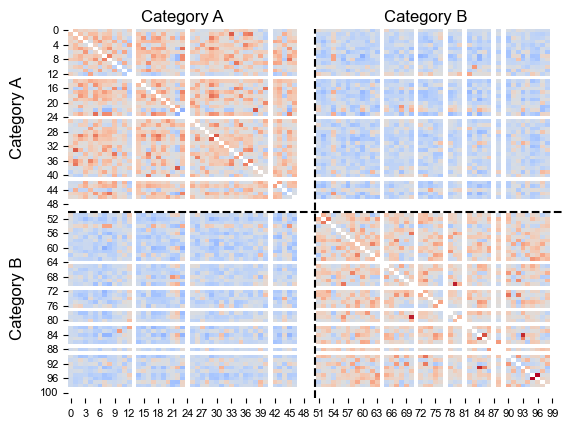

In [281]:
plot_sim_matrix(plt.gca(), representation_matrix)

In [283]:
cat_A = np.nanmean(representation_matrix[:51, :51])
cat_B = np.nanmean(representation_matrix[51:, 51:])
intercat = np.nanmean(representation_matrix[:51, 51:])

In [287]:
(cat_A + cat_B - 2*intercat)

0.2825525116128036

It works for a mouse, lets do it for all mice:

In [313]:
dbase = db.get_sessions()
#take out vg33 and vg34 #still not processed 
working_dbase = dbase[~dbase['mname'].isin(['VG33', 'VG34'])].copy()
working_dbase.loc[:, "name_round"] = working_dbase["mname"] + "_"+ working_dbase["round_id"].astype(str)

In [314]:
sessions = working_dbase["session"].unique()
areas = ['V1', 'medial', 'lateral', 'anterior']
celltype = ['Pyr', 'Int'] 
nmice = working_dbase["name_round"].nunique()
nareas = len(areas)
ncelltypes = len(celltype)
n_sessions = len(sessions)

In [321]:
rep_mtx_all = np.full((nmice, n_sessions, nareas, ncelltypes, 102, 102), np.nan, dtype=float)
for iss, sess in enumerate(sessions):
    d = working_dbase.query(f"session == '{sess}'")
    print(f"Processing: {sess}")
    for i, (_, row) in enumerate(d.iterrows()):
        name, datexp, blk = row["mname"], row["datexp"], row["blk"]
        m = utils.load_mouse(name, datexp, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
        frameselector = utils.get_frameselector(m)
        istim_df = pd.DataFrame(m._timeline['istim'], columns=['istim'])
        istim_df["trial_no"] = np.arange(1, len(istim_df)+1).astype(float)
        m.frameselector = (frameselector.reset_index()
            .rename(columns = {'index':'frame'})
            .merge(istim_df, left_on='trial_no', right_on='trial_no', how='left')
            .set_index('frame'))
        mask_B = m.frameselector['trial_type'].isin(['non rewarded', 'non rewarded test'])
        base = m.frameselector['istim'].astype('Int64') - 1  # zero-based
        m.frameselector['stim_id_matrix'] = np.where(~mask_B, base, base + 51)
        for ia, area in enumerate(areas):
            for ic, ctype in enumerate(celltype):
                print(f"Processing area: {area}, celltype: {ctype}")
                stim_mtx = get_istim_matrix(m, area=area, celltype=ctype, cc_tsh=0.1)
                representation_matrix = get_rsm(stim_mtx)
                rep_mtx_all[i, iss, ia, ic, :, :] = representation_matrix
        clear_output(wait=True)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG24\2025_07_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
Processing area: V1, celltype: Pyr
(343, 102, 2)
Processing area: V1, celltype: Int
(115, 102, 2)
Processing area: medial, celltype: Pyr
(439, 102, 2)
Processing area: medial, celltype: Int
(278, 102, 2)
Processing area: lateral, celltype: Pyr
(233, 102, 2)
Processing area: lateral, celltype: Int
(91, 102, 2)
Processing area: anterior, celltype: Pyr
(145, 102, 2)
Processing area: anterior, celltype: Int
(19, 102, 2)


In [ ]:
cat_A = np.nanmean(representation_matrix[:51, :51])
cat_B = np.nanmean(representation_matrix[51:, 51:])
intercat = np.nanmean(representation_matrix[:51, 51:])
IIndex = (cat_A + cat_B - 2*intercat)

C:\Users\labadmin\AppData\Local\Temp\ipykernel_30144\2160476310.py:6: RuntimeWarning: Mean of empty slice
  mean_over_mice = np.nanmean(rep_mtx_all, axis=0)  # -> (n_sessions, nareas, ncelltypes, 102, 102)


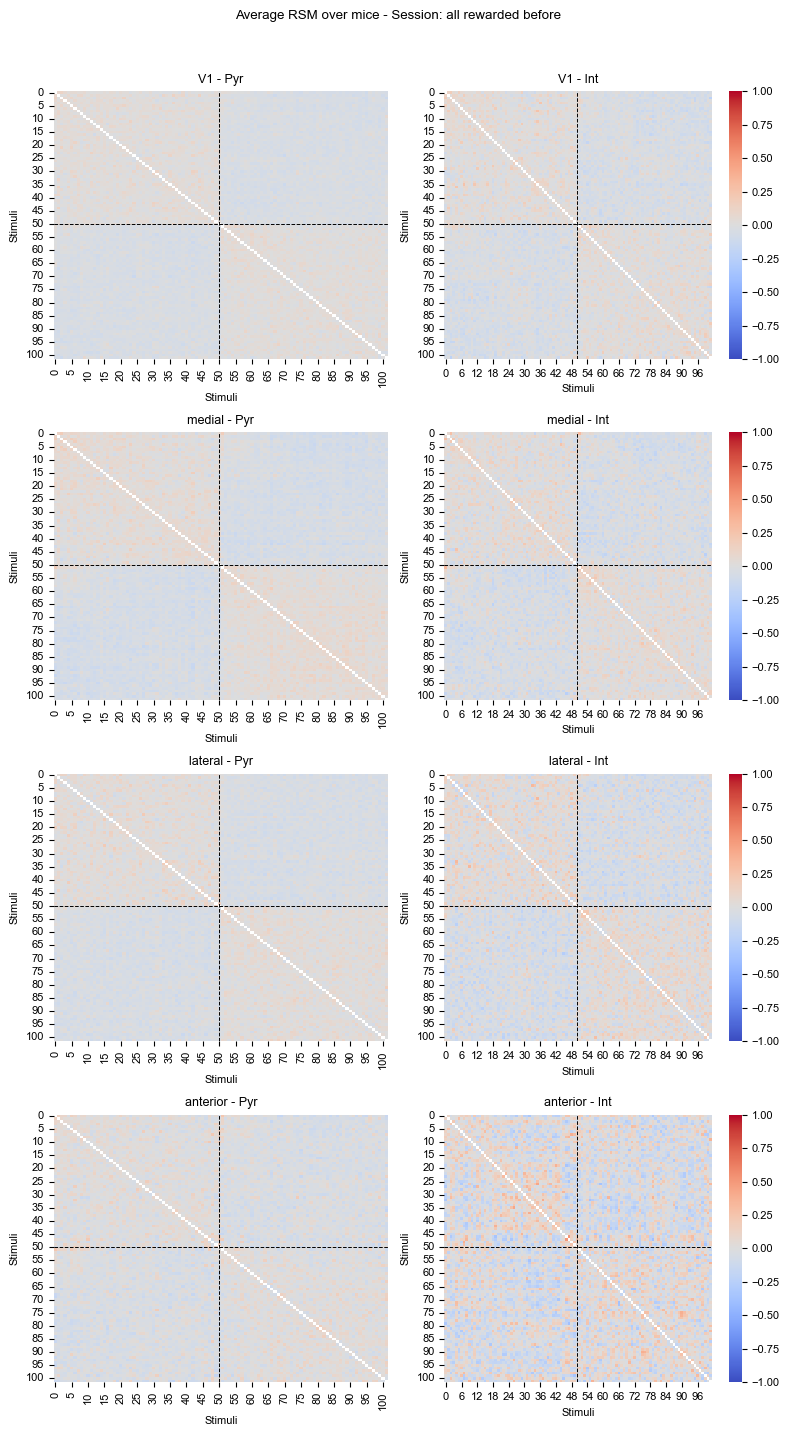

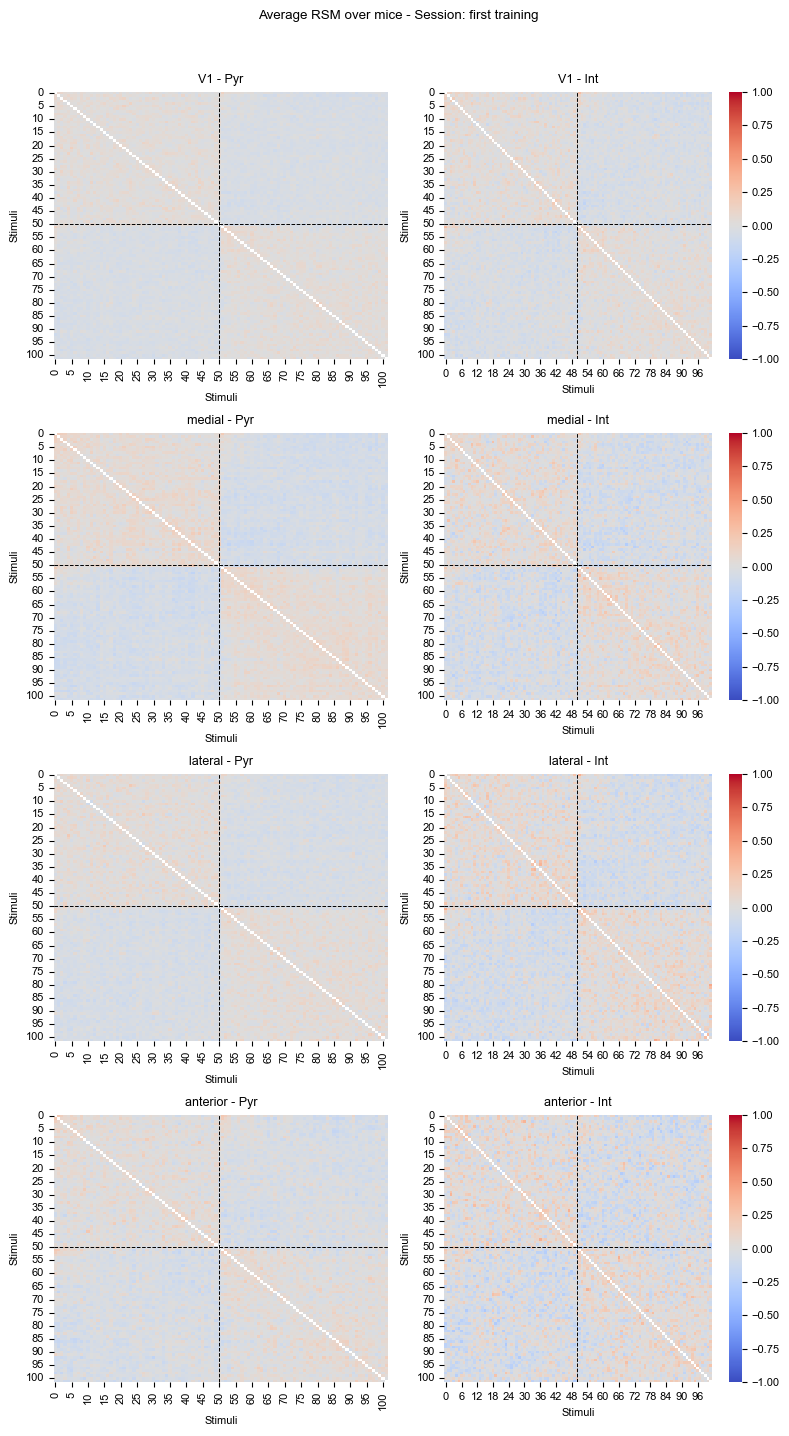

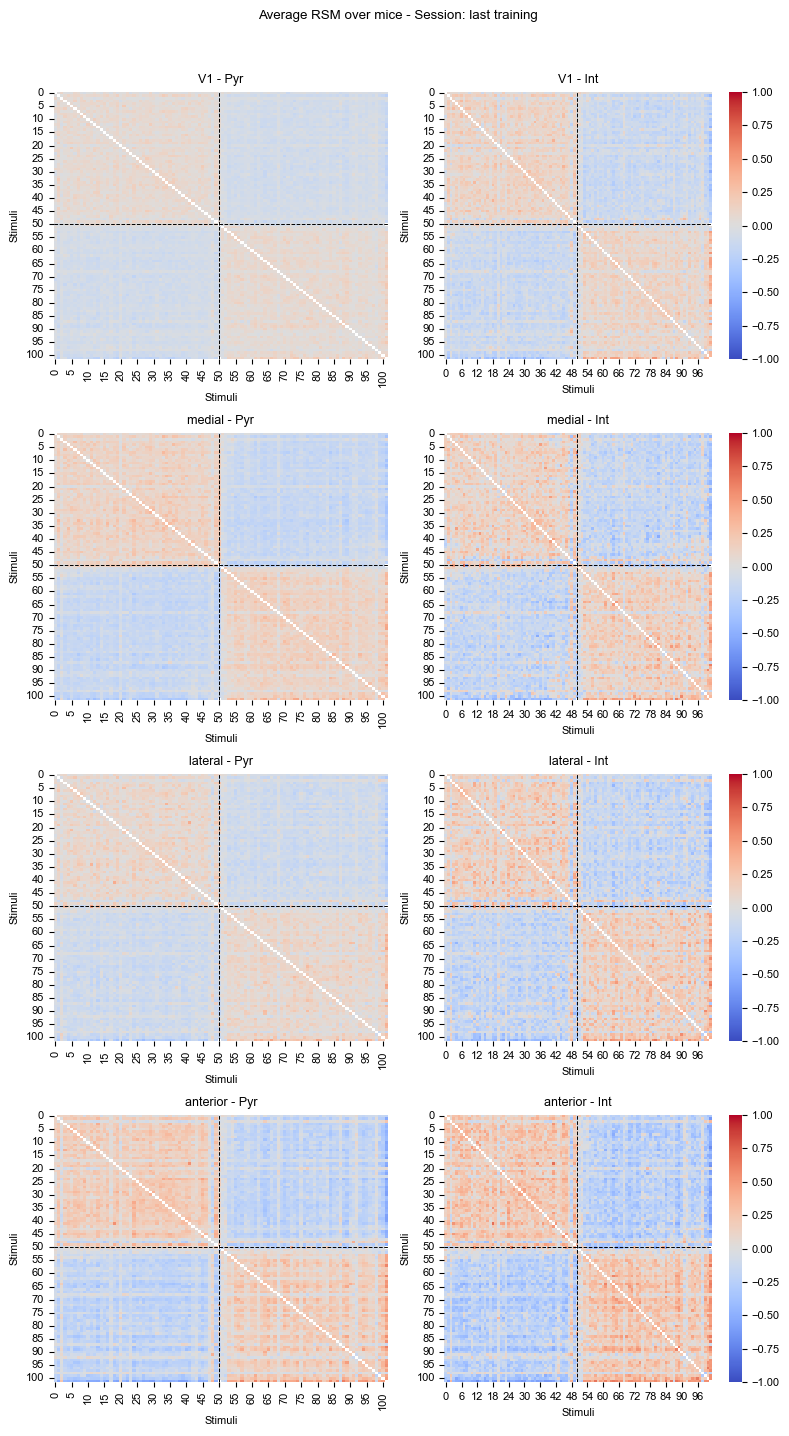

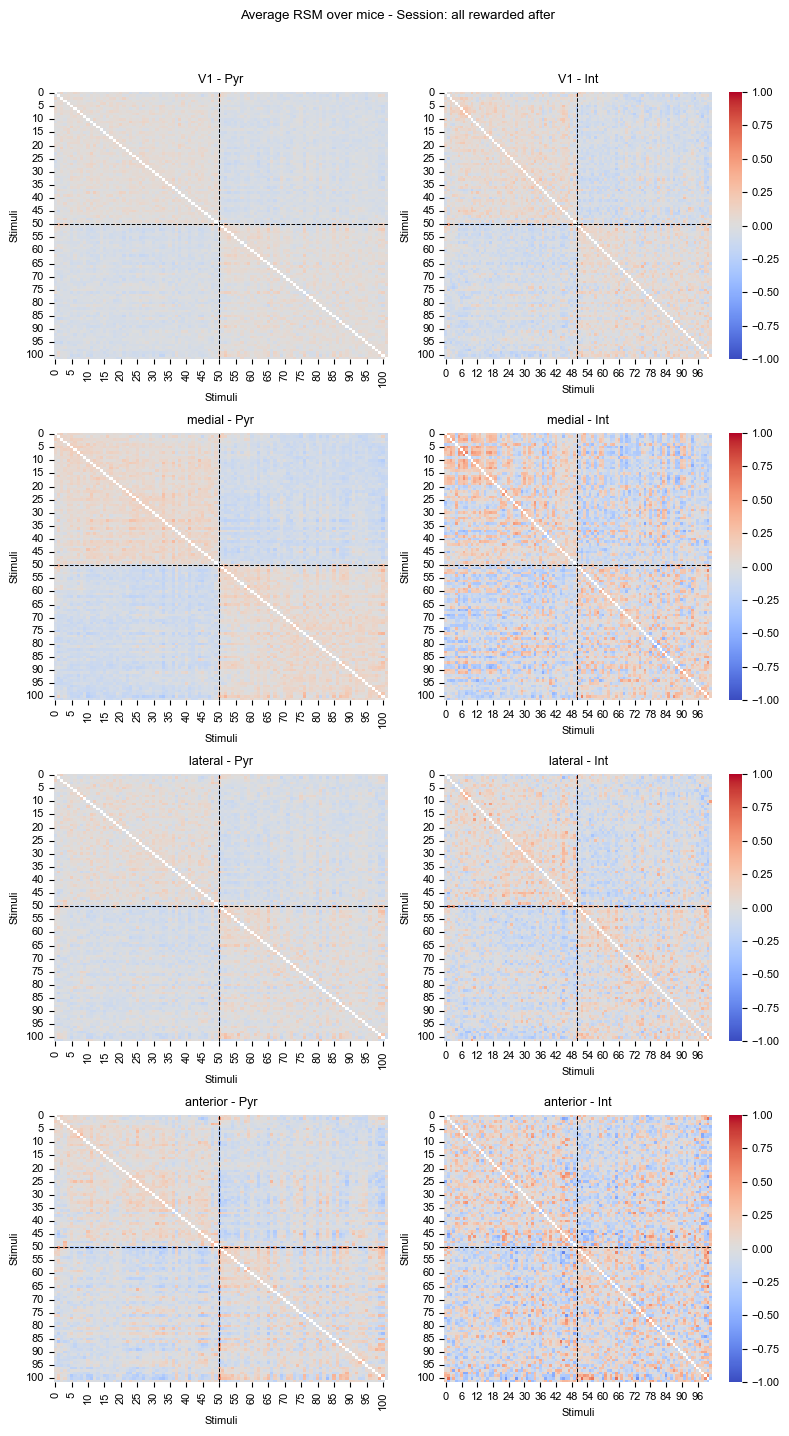

In [322]:
def plot_avg_rsms_over_mice(rep_mtx_all, sessions, areas, celltypes, vmin=-1, vmax=1):
    """
    rep_mtx_all: (nmice, n_sessions, nareas, ncelltypes, 102, 102)
    Plots mean over mice for each session x area x celltype.
    """
    mean_over_mice = np.nanmean(rep_mtx_all, axis=0)  # -> (n_sessions, nareas, ncelltypes, 102, 102)

    for iss, sess in enumerate(sessions):
        fig, axes = plt.subplots(len(areas), len(celltypes), figsize=(4*len(celltypes), 3.5*len(areas)), squeeze=False)
        fig.suptitle(f"Average RSM over mice - Session: {sess}", y=1.02)
        for ia, area in enumerate(areas):
            for ic, ctype in enumerate(celltypes):
                ax = axes[ia, ic]
                avg_mtx = mean_over_mice[iss, ia, ic, :, :]
                if np.isnan(avg_mtx).all():
                    ax.axis('off')
                    ax.set_title(f"{area} - {ctype}\n(no data)")
                    continue
                sns.heatmap(avg_mtx, ax=ax, cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, cbar=(ic == len(celltypes)-1))
                # category separators
                ax.axvline(50.5, color='k', linestyle='--', linewidth=0.7)
                ax.axhline(50.5, color='k', linestyle='--', linewidth=0.7)
                ax.set_title(f"{area} - {ctype}", fontsize=9)
                ax.set_xlabel("Stimuli")
                ax.set_ylabel("Stimuli")
        plt.tight_layout()
        plt.show()

# call:
plot_avg_rsms_over_mice(rep_mtx_all, sessions, areas, celltype)

,mouse,session,area,celltype,Invariance
0,VG11_1,all rewarded before,V1,Pyr,0.111844
1,VG11_1,all rewarded before,V1,Int,0.062423
2,VG11_1,all rewarded before,medial,Pyr,0.119095
3,VG11_1,all rewarded before,medial,Int,0.057313
4,VG11_1,all rewarded before,lateral,Pyr,0.160851


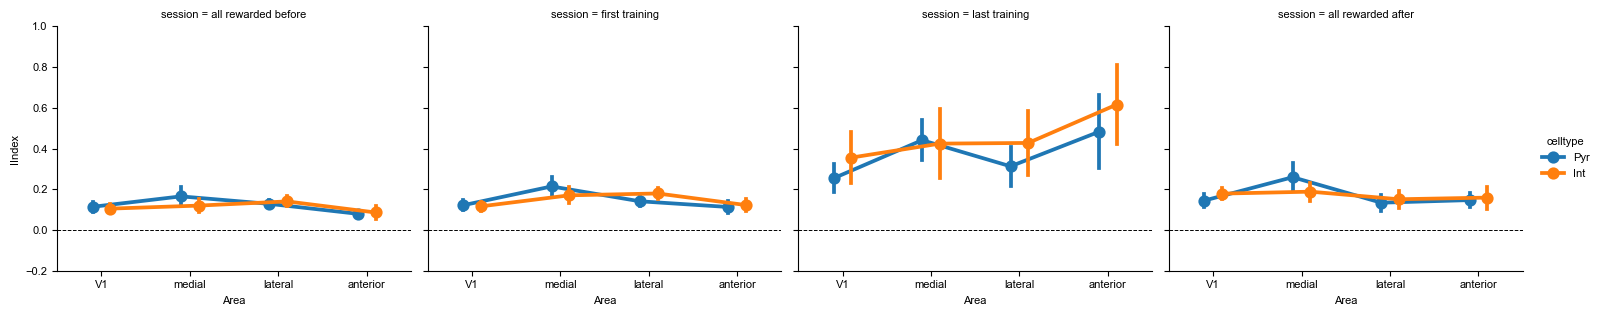

In [331]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_iindex(rsm: np.ndarray) -> float:
    # A: 0..50, B: 51..101
    cat_A = np.nanmean(rsm[:51, :51])
    cat_B = np.nanmean(rsm[51:, 51:])
    intercat = np.nanmean(rsm[:51, 51:])
    return (cat_A + cat_B - 2*intercat)

mouse_keys = working_dbase["name_round"].unique()

rows = []
nmice, n_sessions, nareas, ncelltypes, _, _ = rep_mtx_all.shape
for mi in range(nmice):
    mouse_id = mouse_keys[mi] if mi < len(mouse_keys) else f"mouse_{mi}"
    for iss, sess in enumerate(sessions):
        for ia, area in enumerate(areas):
            for ic, ctype in enumerate(celltype):
                rsm = rep_mtx_all[mi, iss, ia, ic, :, :]
                if np.isnan(rsm).all():
                    continue
                iindex = compute_iindex(rsm)
                rows.append({
                    "mouse": mouse_id,
                    "session": sess,
                    "area": area,
                    "celltype": ctype,
                    "Invariance": iindex
                })

df_iindex = pd.DataFrame(rows)
display(df_iindex.head())

g = sns.catplot(
    data=df_iindex, x="area", y="Invariance",
    hue="celltype", col="session",
    kind="point", errorbar="se",
    order=areas, hue_order=celltype,
    dodge=0.2, height=3.2, aspect=1.2
)
for ax in g.axes.flatten():
    ax.axhline(0, color='k', linestyle='--', linewidth=0.7)
    ax.set_xlabel("Area")
    ax.set_ylabel("IIndex")

plt.ylim(-0.2, 1)
plt.show()

In [336]:
# get only the first training and last training sessions
df_iindex_first_last = df_iindex[df_iindex['session'].isin(["first training", "last training"])].copy()

In [337]:
df_iindex_first_last

,mouse,session,area,celltype,Invariance
8,VG11_1,first training,V1,Pyr,0.136356
9,VG11_1,first training,V1,Int,0.071727
10,VG11_1,first training,medial,Pyr,0.153024
11,VG11_1,first training,medial,Int,0.088562
12,VG11_1,first training,lateral,Pyr,0.168668
...,...,...,...,...,...
147,VG24_1,last training,medial,Int,0.468967
148,VG24_1,last training,lateral,Pyr,0.478189
149,VG24_1,last training,lateral,Int,0.326031
150,VG24_1,last training,anterior,Pyr,0.536195


Area: V1, Celltype: Pyr, t-statistic: -1.982, p-value: 0.0592
Area: V1, Celltype: Int, t-statistic: -1.997, p-value: 0.0582
Area: medial, Celltype: Pyr, t-statistic: -2.347, p-value: 0.0394
Area: medial, Celltype: Int, t-statistic: -1.337, p-value: 0.1261
Area: lateral, Celltype: Pyr, t-statistic: -1.779, p-value: 0.0749
Area: lateral, Celltype: Int, t-statistic: -1.497, p-value: 0.1044
Area: anterior, Celltype: Pyr, t-statistic: -2.165, p-value: 0.0482
Area: anterior, Celltype: Int, t-statistic: -2.625, p-value: 0.0293


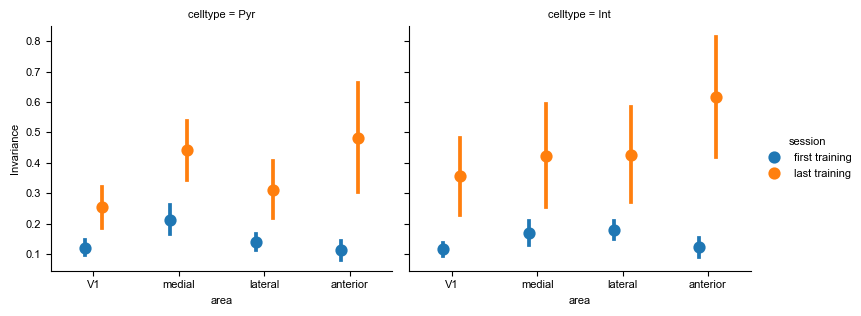

In [342]:
g = sns.catplot(
    data=df_iindex_first_last, x="area", y="Invariance",
    hue="session", col="celltype",
    kind="point", errorbar="se", linestyle="none",
    order=areas, hue_order=["first training", "last training"],
    dodge=0.2, height=3.2, aspect=1.2
)

# now lets apply paired t-test across mice for each area x celltype
# get unique areas and celltypes
from scipy import stats
areas = df_iindex_first_last['area'].unique()
celltypes = df_iindex_first_last['celltype'].unique()
for area in areas:
    for ctype in celltypes:
        data_subset = df_iindex_first_last[
            (df_iindex_first_last['area'] == area) & 
            (df_iindex_first_last['celltype'] == ctype)
        ]
        first_values = data_subset[data_subset['session'] == 'first training']['Invariance']
        last_values = data_subset[data_subset['session'] == 'last training']['Invariance']
        # ensure we have paired data
        common_mice = set(data_subset[data_subset['session'] == 'first training']['mouse']).intersection(
            set(data_subset[data_subset['session'] == 'last training']['mouse'])
        )
        first_values = first_values[data_subset['mouse'].isin(common_mice)]
        last_values = last_values[data_subset['mouse'].isin(common_mice)]
        t_stat, p_value = stats.ttest_rel(first_values, last_values ,alternative='less')
        print(f"Area: {area}, Celltype: {ctype}, t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")